In [5]:
import json 
import pandas as pd
from bs4 import BeautifulSoup
import re
from transformers import BertTokenizer
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling1D, Lambda
from sklearn.model_selection import train_test_split
from transformers import TFBertModel
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sqlalchemy import create_engine
import os
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import json

c:\Users\Alex\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
filename_pkl = 'restaurants_reviews.pkl'
filename_tskv = 'geo-reviews-dataset-2023.tskv'
filename_json = 'geo-reviews-dataset-2023.json'

Поскольку по ТЗ даётся json dataset, а мню был найден хороший tskv датасет от Яндекса, то я сначала перевожу tskv в json, а уже потом в pkl ¯\_(ツ)_/¯

In [3]:
def tskv_to_dataframe(tskv_file_path):
    with open(tskv_file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
    
    data = []
    for line in lines:
        line_data = {}
        pairs = line.strip().split('\t')
        for pair in pairs:
            if pair:
                key, value = pair.split('=', 1)
                line_data[key] = value
        data.append(line_data)
    
    return pd.DataFrame(data)
def tsv2json(input_file, output_file):
    arr = []
    
    with open(input_file, 'r', encoding='utf-8') as file:
        for line in file:
            items = line.split('\t')
            d = {}
            for item in items:
                key, value = item.split('=', 1)
                d[key.strip()] = value.strip()
            arr.append(d)
    
    with open(output_file, 'w', encoding='utf-8') as file:
        json.dump(arr, file, ensure_ascii=False, indent=4)

непосредственно функция для перевода tskv в json и запись в файл жсона

In [6]:
tsv2json(filename_tskv,filename_json)

In [7]:
df = pd.read_json(filename_json, encoding='utf-8')
df_restaurants = df[df['rubrics'].str.contains('Ресторан', case=False)]

открываем жсон(если мы закрыли Юпитер до этого шага) и переводим его в датафрейм

In [8]:
nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))
def clean_text(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r'[^\w\s]', '', text)  
    text = text.lower()
    text = ' '.join(word for word in text.split() if word not in stop_words)
      
    
    return text



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alex\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


функция очистки текста от хтмл тегов, знаков препинания, стоп слов и перевод в нижний регистр

In [9]:
df_restaurants['text'] = df_restaurants['text'].apply(clean_text)
df_restaurants.drop_duplicates(subset=['text'], inplace=True)
df_restaurants.to_pickle(filename_pkl)


C:\Users\Alex\AppData\Local\Temp\ipykernel_10300\242290245.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()
C:\Users\Alex\AppData\Local\Temp\ipykernel_10300\2848955659.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_restaurants['text'] = df_restaurants['text'].apply(clean_text)
C:\Users\Alex\AppData\Local\Temp\ipykernel_10300\2848955659.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df

применяем функцию очистки текста к нашему pkl и убираем дубликаты, записываем датафрейм в pkl файл

In [10]:
def rating_to_label(rating):
    if rating <= 2:
        return 0  
    elif rating >= 4:
        return 1  
    else:
        return None 
df_restaurants['label'] = df_restaurants['rating'].apply(rating_to_label)
df_restaurants = df_restaurants.dropna(subset=['label'])
df_restaurants.to_pickle(filename_pkl)

C:\Users\Alex\AppData\Local\Temp\ipykernel_10300\1113290001.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_restaurants['label'] = df_restaurants['rating'].apply(rating_to_label)


Функция для присвоения меток нашим отзывам. Если отзыв хороший, то метка 1; если отзыв плохой, то метка 0; если отзыв нейтральный, то дропаем отзыв(кому нужны плохие отзывы? ну и пожалейте мой компьютер, ему еще это обучать)

In [11]:
df_restaurants = pd.read_pickle(filename_pkl)
df_restaurants

,address,name_ru,rating,rubrics,text,label
13,"Краснодарский край, городской округ Сочи, посё...",Пандок,2,Ресторан,самый большой плюс это месторасположение набер...,0.0
14,"Краснодарский край, городской округ Сочи, посё...",Пандок,5,Ресторан,добрый день сегодня второй посетили дочкой рес...,1.0
23,"Московская область, Орехово-Зуевский городской...",Пицца РИО,5,Кафе;Ресторан;Столовая,очень вкусно домашнему замечательный комплексн...,1.0
68,"Омск, улица 70 лет Октября, 19",Корова на бочке,5,"Ресторан;Бар, паб",прекрасное заведение хожу лет меню портится ис...,1.0
138,"Ярославль, площадь Труда, 1",IZI kitchen,4,Ресторан;Кафе,отлично место обстановка обслуживание высоте с...,1.0
...,...,...,...,...,...,...
499799,"Республика Крым, Ялта, набережная имени В.И. Л...",Hispaniola Lounge,5,Ресторан,безумно понравилось это заведение часто ужинал...,1.0
499817,"Ставрополь, улица Дзержинского, 160",Клюква,5,Ресторан,очень понравилосьnnединственный минус ждали ед...,1.0
499988,"Москва, улица Юных Ленинцев, 52",Petruccio. Pizza&Pasta,5,Ресторан;Кафе;Пиццерия,очень вкусная пицца нравится система лояльност...,1.0
499989,"Москва, улица Юных Ленинцев, 52",Petruccio. Pizza&Pasta,5,Ресторан;Кафе;Пиццерия,пицца детям понравилась интерьер очень интерес...,1.0


Заново считываем датафрейм(если Ноутбук был закрыт после очистки текста)

In [12]:
texts = df_restaurants['text'].tolist()
labels = df_restaurants['label'].tolist()
tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')
tokens = tokenizer(texts, padding=True, truncation=True, max_length=100, return_tensors="tf")
input_ids = tokens['input_ids']
attention_masks = tokens['attention_mask']

input_ids_np = input_ids.numpy()
attention_masks_np = attention_masks.numpy()

train_inputs, test_inputs, train_labels, test_labels = train_test_split(
    input_ids_np, labels, test_size=0.2, random_state=42)
train_masks, test_masks = train_test_split(
    attention_masks_np, test_size=0.2, random_state=42)

train_inputs = tf.convert_to_tensor(train_inputs)
test_inputs = tf.convert_to_tensor(test_inputs)
train_masks = tf.convert_to_tensor(train_masks)
test_masks = tf.convert_to_tensor(test_masks)
train_labels = tf.convert_to_tensor(train_labels)
test_labels = tf.convert_to_tensor(test_labels)


токенизируем текст, делаем падинги до сотки, переводим получившийся текст и метки в нампи(train_test_split отказывается делить тензоры), разбиваем на обучающие и тестовые выборки, возвращаем обратно тензоры

In [13]:
bert_model = TFBertModel.from_pretrained('DeepPavlov/rubert-base-cased',  from_pt=True)

input_ids = Input(shape=(100,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(100,), dtype=tf.int32, name='attention_mask')

def bert_layer(inputs):
    input_ids, attention_mask = inputs
    return bert_model(input_ids=input_ids, attention_mask=attention_mask)[0]

bert_output = Lambda(bert_layer, output_shape=(100, 768))([input_ids, attention_mask]) 
x = GlobalAveragePooling1D()(bert_output)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'bert.embeddings.position_ids', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

загружаем предобученную модель Берт, получаем токены и маску для них(какие токены следует учитывать), оборачиваем нашу Берту в лямбду(с размерностью (100, 768), где 100 — это количество токенов, а 768 — размер скрытого состояния) и накидываем следующие слои:
1. GlobalAveragePooling1D -  производим выходной тензор размерности (768,). Это позволяет получить одно векторное представление для всей последовательности
2. Dropout(0.3) - случайным образом обнуляем 30% выходных значений. Это помогает предотвратить переобучение модели
3. Dense - выходной  слоей с одним нейроном, функция активации sigmoid. Выдает вероятность между 0 и 1

In [15]:
model = Model(inputs=[input_ids, attention_mask], outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
    filepath='model_reviews.keras',  
    save_best_only=True,             
    monitor='val_loss',              
    mode='min',                      
    save_weights_only=False,         
    verbose=1                        
)


history = model.fit(
    [train_inputs, train_masks],
    train_labels,
    validation_data=([test_inputs, test_masks], test_labels),
    epochs=50,
    batch_size=16,
    callbacks=[early_stopping, model_checkpoint],

)

Epoch 1/50
2685/2685 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.9293 - loss: 0.1833
Epoch 1: val_loss improved from inf to 0.12936, saving model to model_reviews.keras
2685/2685 ━━━━━━━━━━━━━━━━━━━━ 2180s 809ms/step - accuracy: 0.9293 - loss: 0.1833 - val_accuracy: 0.9525 - val_loss: 0.1294
Epoch 2/50
2685/2685 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.9493 - loss: 0.1356
Epoch 2: val_loss improved from 0.12936 to 0.12459, saving model to model_reviews.keras
2685/2685 ━━━━━━━━━━━━━━━━━━━━ 2089s 778ms/step - accuracy: 0.9493 - loss: 0.1356 - val_accuracy: 0.9538 - val_loss: 0.1246
Epoch 3/50
2685/2685 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step - accuracy: 0.9472 - loss: 0.1346
Epoch 3: val_loss improved from 0.12459 to 0.12319, saving model to model_reviews.keras
2685/2685 ━━━━━━━━━━━━━━━━━━━━ 2096s 781ms/step - accuracy: 0.9472 - loss: 0.1346 - val_accuracy: 0.9560 - val_loss: 0.1232
Epoch 4/50
2685/2685 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - accuracy: 0.9474 - loss: 0.1384
Epoch 4:

Настраиваем модель с добавлением колбэков early_stopping(обучение остановится, если модель начнет переобучаться) и model_checkpoint(сохранение модели на каждой эпохе), обучаем модель

In [11]:
model = tf.keras.models.load_model('model_reviews.keras', custom_objects={'bert_layer': bert_layer})

загрузка уже обученной нашей модели

In [16]:
bert_model = TFBertModel.from_pretrained('DeepPavlov/rubert-base-cased',  from_pt=True)
loss, accuracy = model.evaluate([test_inputs, test_masks], test_labels)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'bert.embeddings.position_ids', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

336/336 ━━━━━━━━━━━━━━━━━━━━ 502s 1s/step - accuracy: 0.9583 - loss: 0.1071
Loss: 0.106716088950634
Accuracy: 0.9586669206619263


статистика

In [13]:
def export_db_to_pkl(db_path, table_name, db_pkl):
    engine = create_engine(f'sqlite:///{db_path}')
    conn = engine.connect()

    df = pd.read_sql_table(table_name, conn)
    df.to_pickle(db_pkl)
    print(df)

    conn.close()


current_dir = os.getcwd()
table_name = 'classification_results'
db_path = os.path.join(current_dir, 'reviews.db')
db_pkl = os.path.join(current_dir, 'db_pkl.pkl')
export_db_to_pkl(db_path, table_name, db_pkl)

   id                                        review_text  predicted_rating
0   1  хороший ресторан, готовят вкусно, буду рекомен...          0.999977
1   2  заходил сюда последний раз. Еда очень не вкусн...          0.263995
2   3  классное атмосферное местечко, все вкусно и по...          1.000000
3   4  не советую, цены большие, а еда обычная. Тем б...          0.521043


запись данных с базы данных в pkl файл

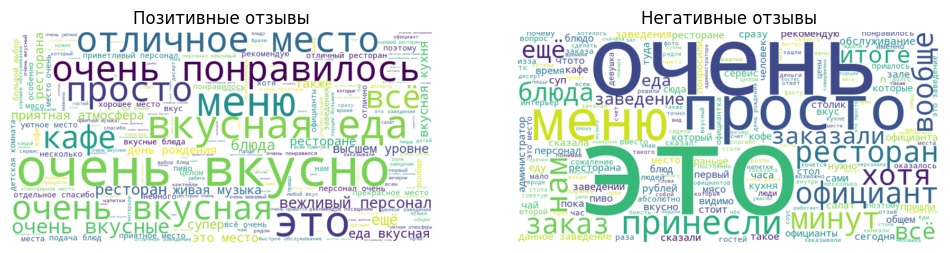

In [14]:
positive_reviews = df_restaurants[df_restaurants['label'] == 1]['text']
negative_reviews = df_restaurants[df_restaurants['label'] == 0]['text']
positive_reviews_string = ' '.join(positive_reviews)
negative_reviews_string = ' '.join(negative_reviews)
positive_cloud = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews_string)
negative_cloud = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews_string)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(positive_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Позитивные отзывы')

plt.subplot(1, 2, 2)
plt.imshow(negative_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Негативные отзывы')

plt.show()

облака частоупотребляемых слов из датасета